In [1]:
import paddle
print(paddle.__version__)

2.5.0-rc0


## 一、MNIST 数据集
> [MNIST handwritten digit database, Yann LeCun, Corinna Cortes and Chris Burges](http://yann.lecun.com/exdb/mnist/)

MNIST 是 NIST 的子集，其中包含有 60,000 个样本的训练集，以及有 10,000 个样本的测试集。
每个图像都是 28x28 的 256 阶灰度图。

加载 paddle 中的 MNIST 数据集

In [2]:
import itertools
import paddle

train_dataset = paddle.vision.datasets.MNIST(mode='train') # 60,000
test_dataset = paddle.vision.datasets.MNIST(mode='test')   # 10,000
print('train images: ',len(train_dataset),', test images: ',len(test_dataset))

train images:  60000 , test images:  10000


`itertools.islice(iterable, start, stop)` 接受一个可迭代对象和两个数字作为参数，会返回 `[start, stop)` 内的元素
下面花了数据集中的前 50 张图像及其标签

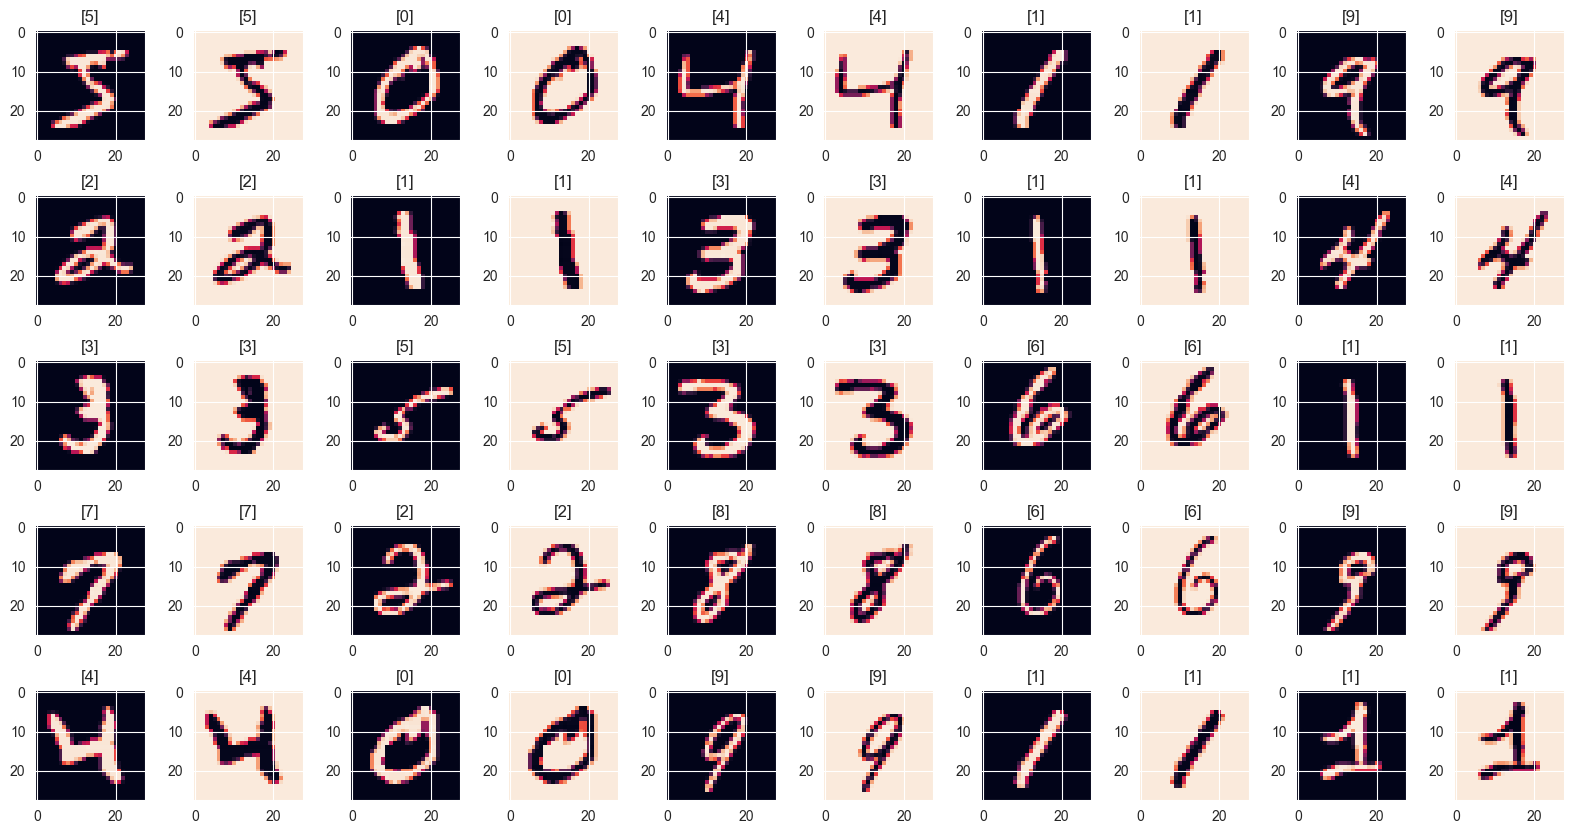

In [16]:
from matplotlib import pyplot as plt
from dataset import train_dataset, test_dataset

plt.figure(figsize=(20, 10))
for i, item in enumerate(itertools.islice(train_dataset, 0, 50)):
    # print(img, label)
    plt.subplot(5, 10, i+1)
    image, label= item
    plt.title(str(label))
    plt.imshow(image.squeeze(0))

plt.subplots_adjust(hspace=0.5)
plt.show()


## 二、网络模型
### LeNet
![LeNet-5.png](./assets/LeNet-5.png)

In [17]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

class LeNet(nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        # 定义卷积层，输出特征通道 out_channels 设置为 6，卷积核的大小 kernel_size 为 5，卷积步长 stride=1，padding=2
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1, stop_axis=-1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

### AlexNet
![AlexNet.png](./assets/AlexNet.png)

In [18]:
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear, Dropout
import paddle.nn.functional as F

class AlexNet(paddle.nn.Layer):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        # AlexNet与LeNet一样也会同时使用卷积和池化层提取图像特征
        # 与LeNet不同的是激活函数换成了‘relu’
        self.conv1 = Conv2D(in_channels=1, out_channels=96, kernel_size=5, stride=1, padding=2)    #out 56  96    第一层改小一点
        # self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)                                                  #out 28
        self.conv2 = Conv2D(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)     # 28
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)                                            # 14
        self.conv3 = Conv2D(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)    #  14
        self.conv4 = Conv2D(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)    # 14
        self.conv5 = Conv2D(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)    # 14
        self.max_pool5 = MaxPool2D(kernel_size=2, stride=2)   # 7

        self.fc1 = Linear(in_features=12544, out_features=4096)  # 7*7*256
        self.drop_ratio1 = 0.5
        self.drop1 = Dropout(self.drop_ratio1)
        self.fc2 = Linear(in_features=4096, out_features=4096)
        self.drop_ratio2 = 0.5
        self.drop2 = Dropout(self.drop_ratio2)
        self.fc3 = Linear(in_features=4096, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.max_pool1(x)  #去掉池化层
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.max_pool5(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = F.relu(x)
        # 在全连接之后使用dropout抑制过拟合
        x = self.drop1(x)
        x = self.fc2(x)
        x = F.relu(x)
        # 在全连接之后使用dropout抑制过拟合
        x = self.drop2(x)
        x = self.fc3(x)
        return x

### VGG
![vgg.png](./assets/vgg.png)

In [19]:
class VGG(paddle.nn.Layer):
    def __init__(self):
        super(VGG, self).__init__()

        in_channels = [1, 64, 128, 256, 512, 512]

        self.conv1_1 = Conv2D(in_channels=in_channels[0], out_channels=in_channels[1], kernel_size=3, padding=1, stride=1)     #out 224
        self.conv1_2 = Conv2D(in_channels=in_channels[1], out_channels=in_channels[1], kernel_size=3, padding=1, stride=1)     #  224

        self.conv2_1 = Conv2D(in_channels=in_channels[1], out_channels=in_channels[2], kernel_size=3, padding=1, stride=1)
        self.conv2_2 = Conv2D(in_channels=in_channels[2], out_channels=in_channels[2], kernel_size=3, padding=1, stride=1)

        self.conv3_1 = Conv2D(in_channels=in_channels[2], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)
        self.conv3_2 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)
        self.conv3_3 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)

        self.conv4_1 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)
        self.conv4_2 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)
        self.conv4_3 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)

        self.conv5_1 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)
        self.conv5_2 = Conv2D(in_channels=in_channels[5], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)
        self.conv5_3 = Conv2D(in_channels=in_channels[5], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)

        self.fc1 = paddle.nn.Sequential(paddle.nn.Linear(512 * 7 * 7, 4096), paddle.nn.ReLU())
        self.drop1_ratio = 0.5
        self.dropout1 = paddle.nn.Dropout(self.drop1_ratio, mode='upscale_in_train')
        self.fc2 = paddle.nn.Sequential(paddle.nn.Linear(4096, 4096), paddle.nn.ReLU())

        self.drop2_ratio = 0.5
        self.dropout2 = paddle.nn.Dropout(self.drop2_ratio, mode='upscale_in_train')
        self.fc3 = paddle.nn.Linear(4096, 10)

        self.relu = paddle.nn.ReLU()
        self.pool = MaxPool2D(stride=2, kernel_size=2)

    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        # x = self.pool(x)    #112

        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        # x = self.pool(x)    #56

        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        # x = self.pool(x)    #28

        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.pool(x)

        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        x = self.pool(x)

        x = paddle.flatten(x, 1, -1)
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

## 三、训练
### 使用Momentum优化器

In [20]:
from utils import redirect_stdout

EPOCHS = 20

def train(batch_size, learning_rate):
    with open(f'LeNet-Momentum-{learning_rate}-{batch_size}-train.txt', 'w') as f:
        with redirect_stdout(f):
            # 选择训练网络模型，以LeNet为例
            network = LeNet()
            model = paddle.Model(network)

            def train_model():
                # 使用Momentum优化器
                model.prepare(paddle.optimizer.Momentum(learning_rate=learning_rate, parameters=model.parameters()),
                              paddle.nn.CrossEntropyLoss(),
                              paddle.metric.Accuracy())
                # 模型训练
                model.fit(train_dataset, epochs=EPOCHS, batch_size=batch_size, verbose=1)
                # 保存模型
                model.save(f'./output/Momentum/{learning_rate}/{batch_size}/LeNet-Momentum')

            train_model()